In [1]:
import os

openai_api_key=os.getenv("openai_api_key")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv('deployment_name')
AZURE_OPENAI_ENDPOINT = os.getenv("endpoint")
AZURE_OPENAI_API_VERSION = os.getenv("version")

In [2]:
from langchain.chat_models import AzureChatOpenAI

llm= AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
    openai_api_base=AZURE_OPENAI_ENDPOINT,
    openai_api_key=openai_api_key,
    openai_api_version=AZURE_OPENAI_API_VERSION
)

C:\Users\yash2\AppData\Local\Temp\ipykernel_10332\3069890798.py:3: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm= AzureChatOpenAI(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://soa-openai-sc.openai.azure.com/ to https://soa-openai-sc.openai.azure.com/openai.
  warnings.warn(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specifi

In [3]:
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper(
    k=2
)

google_search = Tool(
    name="google_search",
    func=search.run,
    description="Search Engine",
    max_tokens=100
)

In [4]:
from typing import List, Dict, Optional
from pydantic import BaseModel, Field

class Valid(BaseModel):
    status: bool = Field(description="Validation status either true/false", default=False)
    suggestion: str = Field(description="If status is True, provide detailed improvement suggestions. If status is False, write N/A", default="N/A")

class MatchResult(BaseModel):
    Non_Negotiable: bool = Field(description="Does any of the non_negotiable entites matched, True or False.", default=False)
    Negotiable: bool = Field(description="Does any of the negotiable entites matched, True or False.", default=False)

class ProductDetails(BaseModel):
    Product_id: str=Field(description="Product id")
    description: str=Field(description="Description of the product")
    Matching_Negotiable_Entities: Optional[int] = Field(description="Number of matching negotiable entities", default=0)
    Matching_Non_Negotiable_Entities: Optional[int] = Field(description="Number of matched non-negotiable entities", default=0)

class Product(BaseModel):
    Product_id: Optional[str]
    Manufacturer_Part_No: Optional[str] = Field(alias="Manufacturer Part No. ")
    description: Optional[str]
    stock_type: Optional[int]
    additional_information: Optional[Dict[str, str]]=Field(default_factory={})

class nego_nnego(BaseModel):
    Negotiable_Entities: Optional[List[str]] = Field(description="list of the negotiable entities",default_factory=list)
    Non_Negotiable_Entities: Optional[List[str]] = Field(description="list of non-negotiable entities",default_factory=list)

class State(BaseModel):
    query: Optional[str]=Field(default=" ")
    context: Optional[str]=Field(default=" ")
    Enriched_Query: Optional[str] = Field(description="Reformulate the user query into a well-defined and detailed format", default="N/A")
    valid: Valid=Field(default_factory=Valid)
    count:int=0
    entities:Optional[nego_nnego]=Field(default_factory=nego_nnego)
    products_list: List[Product]
    t_n_f_list: Optional[List[MatchResult]]
    output_2: Optional[List[ProductDetails]]=[]

In [7]:
def google(state:State)->str:
    return {"context":google_search.invoke(state.query)}

In [8]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate

In [9]:
# google_search.invoke("2 in x 2 in x 3/4 in thrd tee C.S")

In [10]:
def query_enrich_1(val):
    system_prompt = """
    You are given a user query along with additional context. Your task is to enrich and reformulate the query into a more detailed and well-structured format.

    **Instructions**:
    - Provide only the enriched query as output, with no extra information or explanations.
    - Use the **user query**, **context**, and any **suggested changes** to expand abbreviations, use full forms, or improve the sentence structure.
    - Do not add any new information that is not present in the **User Query**.
    - Do not introduce any inferred or additional details from the context. Only consider context for resolving abbreviations or making the query more readable.

    **Input**:
    - Query: {query}
    - Context: {context}
    - Suggestion: {suggest}

    **Output**:
    (Enriched Query)

    **Example**:
    User query: 10 2-2-3/4 threaded tee C.S 
    Output: 10 quantities of 2-inch by 2-inch by 3/4-inch threaded tee fitting made of carbon steel (C.S.)

    Do not introduce any information not present in the **User Query**.
"""


    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","suggest"],
    )
    chain = prompt | llm

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":val,
        "context":google_search.invoke(val),
        "suggest":"N/A"
    })
    return response.content

In [11]:
# user_input="3 in sch 10 316 90s 90 degree elbow"
# print(query_enrich_1(user_input))

In [12]:
def query_enrich(state: State)->Dict[str,str]:
    system_prompt = """
    You are given a user query along with additional context. Your task is to enrich and reformulate the query into a more detailed and well-structured format.

    **Instructions**:
    - Provide only the enriched query as output, with no extra information or explanations.
    - Use the **user query**, **context**, and any **suggested changes** to expand abbreviations, use full forms, or improve the sentence structure.
    - Do not add any new information that is not present in the **User Query**.
    - Do not introduce any inferred or additional details from the context. Only consider context for resolving abbreviations or making the query more readable.

    **Input**:
    - Query: {query}
    - Context: {context}
    - Suggestion: {suggest}

    **Output**:
    (Enriched Query)

    **Example**:
    User query: 10 2-2-3/4 threaded tee C.S 
    Output: 10 quantities of 2-inch by 2-inch by 3/4-inch threaded tee fitting made of carbon steel (C.S.)

    Do not introduce any information not present in the **User Query**.
"""



    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","suggest"],
    )
    chain = prompt | llm

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.context,
        "suggest":state.valid.suggestion
    }).content
    return {"Enriched_Query":response}

In [13]:
def valid_1(state: State)->Dict[str,str]:
    system_prompt = """
        You are an expert Supervisor Model tasked with evaluating the quality of outputs generated by an AI agent. Your responsibilities include:
        1. Checking if the output meets the specified expectations.
        2. Providing actionable feedback if the output deviates from expectations.

        ### Evaluation Criteria:
        - **Status**:
        - Mark `status` as **True** if the output does not meet the expectations, and give the example of final output according to you, No explanation.
        - Mark `status` as **False** if the output aligns with expectations, and write "N/A" in the `suggestion` field.

        ### Expectations:
        The output should:
        1. Extract relevant information from the input query and context.
        2. Return the information in a **structured format**, including the following fields:
        - **Product**: The name or type of the product mentioned in the query.
        - **Dimension**: The dimensions of the product, if provided in the context.
        - **Enriched_Query**: A reformulated version of the user query that is well-defined, detailed, and utilizes both the query and context.
        3. Avoid including additional or inferred details not explicitly mentioned in the query or context.

        ### Input Details:
        - **Query**: {query}
        - **Context**: {context}

        ### AI Agent's Output:
        - **Output**: {output}

        ### Required Output:
        You must return:
        status: (True/False) — Whether the output meets expectations.
        suggestion: (If `status` is True, give the final output according to you in form of string, No explanation. If `status` is False, write "N/A".)

        Format:{format}
"""

    parser = JsonOutputParser(pydantic_object=Valid)

    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","output"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.context,
        "output":state.Enriched_Query
    })
    if state.count==2:
        response['status']=False
        response['suggestion']="N/A"

    if response['status'] and state.count<2:
        state.count=state.count+1
    else:
        state.count=0  
    # state.valid=response
    return {
        "valid":response,
        "count":state.count
            }


In [14]:
def condition_1(state:State)->str:
    if state.valid.status and state.count<=2:
        return "repeat"
    return "next"

In [15]:
def entity(state:State)->Dict[str,str]:
    system_prompt = """
        You are an expert data analyzer. Your task is to extract and classify entities from a given query into two categories: **Negotiable entities** and **non-Negotiable entities**.You can also refer to suggestion provided by the validator to give the similar output. Provide the results strictly in the following format below:
        Give only top 2 most important Non-negotiable entities.

        General list of Negotiable entities:
            - Standards or grades (e.g., 10)
            - Variants or options (e.g., short radius)
            - Additional descriptors (e.g., insert)

            General list of non-Negotiable entities:
            - Size (e.g., 3 in, 3/8 - 16)
            - Material (e.g., 316, nylon)
            - Component type (e.g., elbow, locknut)
            - Specification (e.g., schedule sch, 90s)
            - Angle or shape (e.g., 90 degree) 
        
        Go through the suggestion provided by the validator, and give the output according to it.
        Input Query: 
        Original user query:{query}
        Enriched user query:{enrich_query}
        Suggestion:{suggest}

        Output:
        Negotiable_Entities: list of Negotiable entities present in the Input (Use N/A if not found)
        Non_Negotiable_Entities: list of unique non-Negotiable entities present in the Input(Use N/A if not found)

        ### Example:

        Input Query: 
        Original user query: 10 2-2-3/4 threaded tee C.S 
        Enriched user query: 10 quantities of 2-inch by 2-inch by 3/4-inch threaded tee fitting made of carbon steel (C.S.)

        Output:
        Negotiable_Entities: [10, 2-inch by 2-inch by 3/4-inch],
        Non_Negotiable_Entities: ["threaded tee fitting", "carbon steel"]

        ONLY GIVE OUTPUT. DO NOT INCLUDE EXTRA INFORMATION, SYMBOLS, OR TEXT.
        {format}
    """
    parser=JsonOutputParser(pydantic_object=nego_nnego)
    prompt=PromptTemplate(
        template=system_prompt,
        input_variables=["query","enrich_query","suggest"],
        partial_variables={"format":parser.get_format_instructions()}
    )

    chain=prompt | llm | parser

    response=chain.invoke({
        "query":state.query,
        "enrich_query":state.Enriched_Query,
        "suggest":state.valid.suggestion
    })


    return {"entities":response}

In [16]:
def valid_2(state:State)->Dict[str,str]:
    system_prompt = """
        You are a Supervisor Model evaluating the quality of an AI agent's output. Your tasks are to:
        1. Verify if the output meets expectations.
        2. Provide actionable feedback if it deviates from expectations.

        ### Evaluation Criteria:
        **Status**: 
        - Set to **True** if the output does not meet expectations, and give the example of final output according to you, No explanation.
        - Set to **False** if the output meets expectations, and write "N/A" in `suggestion`.
        - For Non-negotiable give only top 2 most important entities.

        ### Expectations:
            General list of Negotiable entities:
            - Standards or grades (e.g., 10)
            - Variants or options (e.g., short radius)
            - Additional descriptors (e.g., insert)

            General list of non-Negotiable entities:
            - Size (e.g., 3 in, 3/8 - 16)
            - Material (e.g., 316, nylon)
            - Component type (e.g., elbow, locknut)
            - Specification (e.g., schedule sch, 90s)
            - Angle or shape (e.g., 90 degree)

        ### Inputs:
        - **User Query**: {query}
        - **Enriched Query**: {context}
        - **AI Output**: {output}

        ### Required Output:
        - `status`: True (if the output deviates) or False (if it meets expectations).
        - `suggestion`: Give the final output according to you in form of string, if `status` is True; "N/A" if `status` is False.

        Output Format: {format}
"""

    parser = JsonOutputParser(pydantic_object=Valid)

    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","output"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.Enriched_Query,
        "output":state.entities
    })
    if state.count==2:
        response['status']=False
        response['suggestion']="N/A"

    if response['status'] and state.count<2:
        state.count=state.count+1
    else:
        state.count=0

    return {
        "valid":response,
        "count":state.count
            }

In [17]:
def t_n_f(state:State)->Dict[str,str]:
    system_prompt = """
    You are an expert at evaluating negotiable and non-negotiable entities in user queries. Given a **user query**, identify and classify the entities as negotiable or non-negotiable. For each entity, determine if it matches the inventory criteria provided.

    The evaluation rules are as follows:
    1) Non-negotiable entities (e.g., size, dimensions, material, component type) must exactly match the provided inventory details. If they match, mark them as true; otherwise, mark them as false.
    2) Negotiable entities (e.g., quantity, variants, finish, coating) are flexible. If they align contextually or partially with inventory details, mark them as true; otherwise, mark them as false.

    **User Query:**
    Negotiable Entites:{Negotiable}
    Non Negotiable Entites: {Non_Negotiable}
    Enriched Query: {query}

    **Inventory Details:**
    {inventory}

    Suggestion for desired output:{suggest}

    **Expected Output Format:**
    Non_Negotiable: True/False
    Negotiable: True/False
    ...

    ONLY GIVE OUTPUT IN THE SPECIFIED FORMAT. NO EXTRA INFORMATION, SYMBOLS, TOKENS, OR TEXT.
    In {format}
"""
    parser=JsonOutputParser(pydantic_object=MatchResult)

    prompt=PromptTemplate(
        template=system_prompt,
        input_variables=["Negotiable","Non_Negotiable","query","inventory","suggest"],
        partial_variables={"format":parser.get_format_instructions()}
    )
    chain = prompt | llm | parser
    # if state.count==2:
    #     state.valid.status=False
    #     state.valid.suggestion="N/A"

    response=chain.invoke({
        "Negotiable":state.entities.Negotiable_Entities,
        "Non_Negotiable":state.entities.Non_Negotiable_Entities,
        "query":state.Enriched_Query,
        "inventory":state.products_list[len(state.t_n_f_list)],
        "suggest":state.valid.suggestion
    })
    # if state.valid.status:
    #     state.t_n_f_list[len(state.t_n_f_list)-1]=response
    # else:
    state.t_n_f_list.append(response)
    # if state.valid.status and state.count<2:
    #     state.count=state.count+1
    # else:
    #     state.count=0
    return {
        "t_n_f_list":state.t_n_f_list
        # "count":state.count,
        # "valid":state.valid
        }


In [20]:
def valid_3(state:State)-> Dict[str,str]:
    system_prompt = """
        You are a validation expert. Your task is to evaluate the correctness of the AI-agent's response based on specific criteria.

        ### Validation Criteria:
        1. **Non-Negotiable Entities Check**: Verify if non-negotiable entities in the user query (e.g., dimensions, material, component type) **exactly match** the corresponding details in the inventory, maintaining the same order and format.  
        - Mark `status` as `False` if they **do match**, otherwise `True`.  

        2. **Negotiable Entities Check**: Assess if negotiable entities in the user query (e.g., quantity, variants, finish, coating) align **contextually** or **partially** with the inventory.  
        - Mark `status` as `False` if they **do align**, otherwise `True`.  

        ### Input Information:
        - **User Input**:
        -  {query}
        - **Inventory Product Details**:
        - {inventory}
        - **AI-Agent Response**:
        - {t_n_f}

        ### Output Requirements:
        - **status**: 
        - `False` if all checks meet expectations.
        - `True` if any check deviates from expectations.
        - **suggestion**:
        - If `status` is `True`: give the final output according to you in form of string, No explanation.
        - If `status` is `False`: Return `"N/A"`.

        ### Format:
        {format}
    """
    parser=JsonOutputParser(pydantic_object=Valid)
    prompts=PromptTemplate(
        template=system_prompt,
        input_variables=["query","inventory","t_n_f"],
        partial_variables={"format":parser.get_format_instructions()}
    )

    chain= prompts | llm | parser
    response=chain.invoke({
        "query":state.Enriched_Query,
        "inventory":state.products_list[len(state.t_n_f_list)-1],
        "t_n_f":state.t_n_f_list[-1]
    })
    
    if state.count==2:
        response['status']=False
        response['suggestion']="N/A"
    elif response['status']==True:
        state.t_n_f_list.pop()

    if response['status'] and state.count<2:
        state.count=state.count+1
    else:
        state.count=0
    
    return {
        "valid":response,
        "t_n_f_list":state.t_n_f_list,
        "count":state.count
            }


In [21]:
def condition_2(state:State)->str:
    if (state.valid.status and state.count<=2)or(len(state.t_n_f_list)<len(state.products_list)):
        return "repeat"
    return "next"

In [22]:
def filter(state: State)-> List[Dict[str,str]]:
    system_prompt="""
        You are an expert product matcher. Your task is to compare the Negotiable entities of a product with its description and count the number of Negotiable entities that seems similar between them. Provide the exact count as an integer. 

        General list of Negotiable entities:
            - Standards or grades (e.g., 10)
            - Variants or options (e.g., short radius)
            - Additional descriptors (e.g., insert) 

        ### Input Format:

        Negotiable Entities: {Negotiable_entities}
        Product Description: {description}

        ### Output Format:
        (number,0 if not matched)

        ### Example:

        Negotiable Entities: ["10 quantites"]  
        Product Description: "10 quantities of a 2-inch by 2-inch by 3/4-inch threaded tee fitting."

        Output:
        2  

        ONLY GIVE OUTPUT IN THE SINGLE INTEGER, NO EXTRA INFORMATION, SYMBOLS, TOKEN OR ANY OTHER TEXT IS NECESSARY
"""
    system_prompt_1="""
        You are an expert product matcher. Your task is to compare the non-Negotiable entities of a product with its description and count the number of Negotiable entities that seems similar between them. Provide the exact count as an integer. 

        General list of non-Negotiable entities:
            - Size (e.g., 3 in, 3/8 - 16)
            - Material (e.g., 316, nylon)
            - Component type (e.g., elbow, locknut)
            - Specification (e.g., schedule sch, 90s)
            - Angle or shape (e.g., 90 degree)
        
        ### Input Format:

        Negotiable Entities: {non_negotiable_entities}
        Product Description: {description}

        ### Output:
        (number)

        ### Example:

        Non_Negotiable Entities: "threaded tee fitting", "carbon steel (C.S.)"
        Product Description: "10 quantities of a 2-inch by 2-inch by 3/4-inch threaded tee fitting."

        Output:
        1   

        ONLY GIVE OUTPUT IN THE SINGLE INTEGER, NO EXTRA INFORMATION, SYMBOLS, TOKEN OR ANY OTHER TEXT IS NECESSARY
    """
    template=ChatPromptTemplate.from_messages({
        ("system",system_prompt)
    })
    template_1=ChatPromptTemplate.from_messages({
        ("system",system_prompt_1)
    })
    temp = []
    parser=JsonOutputParser(pydantic_object=ProductDetails)

    for i in range(len(state.t_n_f_list)):
        # Ensure that each item in t_n_f_list is a dictionary
        current_dict = state.t_n_f_list[i]
        if current_dict.Negotiable or current_dict.Non_Negotiable:
            prompt_value=template.invoke(
                {
                    "Negotiable_entities":state.entities.Negotiable_Entities,
                    "description":state.products_list[i].description
                }
            )
            num=llm.invoke(prompt_value).content
            prompt_value_1=template_1.invoke(
                {
                    "non_negotiable_entities":state.entities.Non_Negotiable_Entities,
                    "description":state.products_list[i].description
                }
            )
            non_num=llm.invoke(prompt_value_1).content
            prompt=PromptTemplate(
                template="""
                            Product id: {id},
                            description:{desp},
                            number of Negotiable entities:{nm},
                            number of non-Negotiable entites:{n_num},
                            In format: {format}
                        """,
                input_variables=["id","desp","nm","n_num"],
                partial_variables={"format":parser.get_format_instructions()}
            )
            chain=prompt | llm | parser
            
            updated_product = chain.invoke({
                "id":state.products_list[i].Product_id,
                "desp":state.products_list[i].description,
                "nm":num,
                "n_num":non_num
            })
            temp.append(updated_product)
    return {'output_2': temp}

In [23]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("search", google)
graph_builder.add_node("enrichment", query_enrich)
graph_builder.add_node("validator_1", valid_1)
graph_builder.add_node("entity",entity)
graph_builder.add_node("validator_2",valid_2)
graph_builder.add_node("t_n_f",t_n_f)
graph_builder.add_node("validator_3",valid_3)
graph_builder.add_node("filter",filter)
graph_builder.add_edge(START, "search")
graph_builder.add_edge("search", "enrichment")
graph_builder.add_edge("enrichment","validator_1")
graph_builder.add_conditional_edges(
    "validator_1",
     condition_1, 
    {
        "repeat": "enrichment",
        "next": "entity"
    }
)
graph_builder.add_edge("entity","validator_2")
graph_builder.add_conditional_edges(
    "validator_2",
     condition_1, 
    {
        "repeat": "entity",
        "next": "t_n_f"
    }
)
graph_builder.add_edge("t_n_f","validator_3")
# graph_builder.add_edge("validator_3",END)
graph_builder.add_conditional_edges(
    "validator_3",
    condition_2,
    {
        "repeat":"t_n_f",
        "next":"filter"
    }
)
graph_builder.add_edge("filter",END)

d:\Yash-Python\Lib\site-packages\langgraph\graph\graph.py:36: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.pregel import Channel, Pregel


In [24]:
graph=graph_builder.compile()

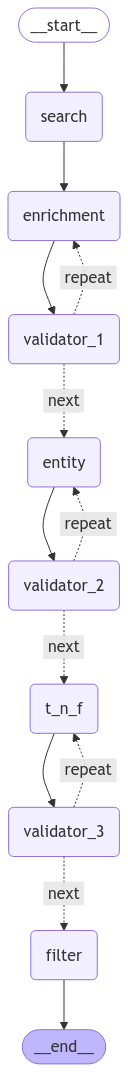

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [26]:
user_input="3 in(inch) schedule sch(schedule) 10 316 90s(90 short radius) 90 degree elbow"

In [27]:
# user_input="Hello how are you!"

In [39]:
context_data=[
    {
        "Product_id": "es8037c",
        "Manufacturer Part No. ": "828150",
        "description": "lock nut measurement system imperial 3/8 in-16 diameter - thread steel/nylon insert 8 grade 16 nylon",
        "stock_type": 1,
        "additional_information": {}
    },
    {
        "Product_id": "es8037cy",
        "Manufacturer Part No. ": "845200",
        "description": "lock nut measurement system imperial 3/8 in-16 diameter - thread steel/nylon insert zinc plated 8 grade yellow 16 nylon",
        "stock_type": 1,
        "additional_information": {}
    },
    {
        "Product_id": "es8037cy/ez",
        "Manufacturer Part No. ": "759032",
        "description": "lock nut measurement system imperial 3/8 in-16 diameter - thread nylon insert zinc plated 8 grade yellow 16",
        "stock_type": 1,
        "additional_information": {}
    },
    {
        "Product_id": "eshn037cz",
        "Manufacturer Part No. ": "37cnnhz",
        "description": "lock nut measurement system imperial 3/8 in-16 diameter - thread nylon insert zinc plated heavy 16",
        "stock_type": 1,
        "additional_information": {}
    }]

In [40]:
# context_data=[
#     {
#         "Product_id": "es8037c",
#         "Manufacturer Part No. ": "828150",
#         "description": "lock nut measurement system imperial 3/8 in-16 diameter - thread steel/nylon insert 8 grade 16 nylon",
#         "stock_type": 1,
#         "additional_information": {}
#     }]

In [41]:
# import json
# with open('context_data_3.json', 'r') as f:
#     context_data = json.load(f)

In [42]:
from langgraph.errors import GraphRecursionError

try:
    response = graph.invoke(
            {
                "query": user_input,
                "valid": Valid(status=True, suggestion="No no"),
                "Enriched_Query":"",
                "count":0,
                "products_list": context_data,
                "t_n_f_list":[]
            }, {"recursion_limit": 10000}
        )
except GraphRecursionError:
    print("Recursion Error")


In [43]:
response['Enriched_Query']

'3-inch schedule 10 316 stainless steel 90-degree short radius elbow'

In [44]:
response['t_n_f_list']

[MatchResult(Non_Negotiable=False, Negotiable=False),
 MatchResult(Non_Negotiable=False, Negotiable=False),
 MatchResult(Non_Negotiable=False, Negotiable=False),
 MatchResult(Non_Negotiable=False, Negotiable=False)]

In [45]:
response['valid']

{'status': False, 'suggestion': 'N/A'}

In [46]:
response['count']

0

In [47]:
response['entities']

{'Negotiable_Entities': ['10', '90 short radius'],
 'Non_Negotiable_Entities': ['3 in', '316']}

In [48]:
response['output_2'].sort(key=lambda x: (x['Matching_Negotiable_Entities'], x['Matching_Non_Negotiable_Entities']), reverse=True)

In [49]:
response['output_2']

[]